In [113]:
# 导入所需要的模块
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn import tree

In [120]:
# 加载训练集
data=pd.read_csv('train.csv')
data.shape

(891, 12)

In [121]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [122]:
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [123]:
data.loc[:,"Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [124]:
#整理数据

##去除明显不必要的特征
data.drop(["PassengerId",'Name','Ticket','Cabin',],inplace=True,axis=1)

##补齐缺失值
data.loc[:,'Age']=data.loc[:,'Age'].fillna(data.loc[:,'Age'].mean())

##去除无法补齐缺失值的样本
data=data.dropna()

##将分类变量Sex编码
data.loc[:,'Sex']=(data.loc[:,'Sex']=='male').astype('int')

##将分类变量Embarked编码
labels=data.loc[:,'Embarked'].unique().tolist() 
data.loc[:,'Embarked']=data.loc[:,'Embarked'].apply(lambda x:labels.index(x))

In [129]:
#准备数据

##划分因变量与自变量
y=data.loc[:,data.columns=='Survived']
x=data.loc[:,data.columns!='Survived']

##切割训练集与测试集
x_train,x_test,y_train,y_test=train_test_split(x,y,
                                               test_size=0.3
                                              ,random_state=0)

##重新对训练集与测试集的index进行编码
###用x_train=x_train.reset_index(drop=True)或者用下列循环
for i in [x_train,x_test,y_train,y_test]:
    i.index=range(i.shape[0])

In [130]:
#建立模型
##比较选择参数splitter的值

# clf=DecisionTreeClassifier(random_state=0
#                           ,criterion='entropy'
#                           ,splitter='best'
#                           ,max_depth=4
#                           )
# score_splitter_best=cross_val_score(clf,x,y,cv=10).mean()

# clf=DecisionTreeClassifier(random_state=0
#                           ,criterion='entropy'
#                           ,splitter='random'
#                           ,max_depth=4
#                           )
# score_splitter_random=cross_val_score(clf,x,y,cv=10).mean()
# print("参数为best的score：{}".format(score_splitter_best),
#       "\n参数为random的score:{}".format(score_splitter_random))

for i in ["best", "random"]:
    clf = DecisionTreeClassifier(random_state = 0
                                ,criterion = "entropy"
                                ,splitter= i
                                ,max_depth = 4
                                )
    score = cross_val_score(clf,x,y,cv=10).mean()
    print("参数为"+i+"的score：{}".format(score))

参数为best的score：0.8009576098059246
参数为random的score：0.8053881511746681


In [10]:
##比较选择参数criterion的值
for i in ["entropy", "gini"]:
    clf = DecisionTreeClassifier(random_state = 0
                                ,criterion = i
                                ,splitter= "random"
                                ,max_depth = 4
                                )
    score = cross_val_score(clf,x,y,cv=10).mean()
    print("参数为"+i+"的score：{}".format(score))

参数为entropy的score：0.8076608784473953
参数为gini的score：0.8020429009193053


0.8279111338100102 7


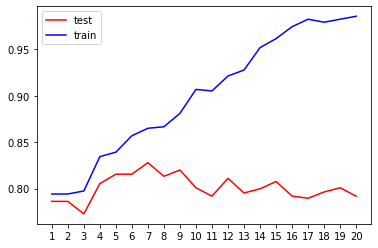

In [131]:
##画参数max_depth的超越曲线，选定max_depth的值
train=[]
test=[]
for i in range(20):
    clf=DecisionTreeClassifier(random_state=0
                               ,criterion='entropy'
                               ,splitter='random'
                               ,max_depth=i+1
                              )
    clf=clf.fit(x_train,y_train)
    score_train=clf.score(x_train,y_train)
    score_test=cross_val_score(clf,x,y,cv=10).mean()
    test.append(score_test)
    train.append(score_train)
print(max(test),test.index(max(test))+1)
plt.plot(range(1,21),test,color='red',label='test')
plt.plot(range(1,21),train,color='blue',label='train')
plt.xticks(range(1,21)) #横轴的样式
plt.legend() #现实图例

# 网格搜索

In [132]:
##创建参数篮子
import numpy as np

parameters={'criterion':('gini','entropy')
            #,'spliter':('best','random')
            ,'max_depth':[*range(1,11)]
            ,'min_samples_leaf':[*range(1,51,10)]
            ,'min_impurity_decrease':[*np.linspace(0,1,21)] #np.linspace是创建了等差数列
           }

In [133]:
clf=DecisionTreeClassifier(splitter="best")
GS=GridSearchCV(clf,parameters,cv=10,n_jobs=-1)
GS=GS.fit(x_train,y_train)
print(GS.best_params_)#返回最佳组合
print(GS.best_score_)

{'criterion': 'entropy', 'max_depth': 6, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}
0.8360727086533537


In [134]:
clf=DecisionTreeClassifier(splitter="random")
GS=GridSearchCV(clf,parameters,cv=10,n_jobs=-1)
GS=GS.fit(x_train,y_train)
print(GS.best_params_)#返回最佳组合
print(GS.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1}
0.8311827956989246


In [142]:
clf=DecisionTreeClassifier(criterion='entropy'
                           ,splitter='best'
                           ,max_depth=6
                           ,min_impurity_decrease=0.0
                           ,min_samples_leaf=1
                          )
clf=clf.fit(x_train,y_train)
score=clf.score(x_test,y_test)
score

0.7940074906367042

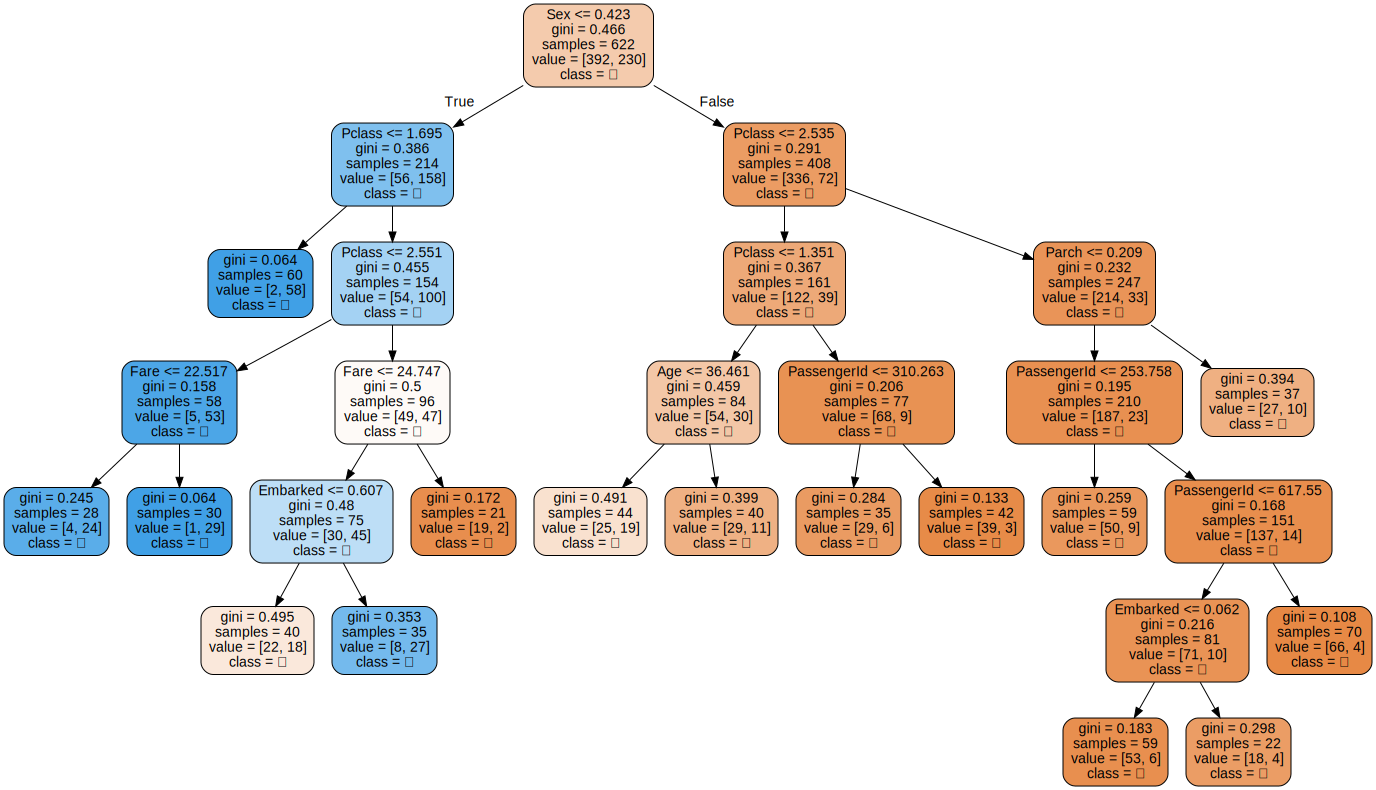

In [23]:
#画决策树流程图
feature_name=x_train.columns.tolist()

dot_data=tree.export_graphviz(clf
                             ,feature_names=feature_name
                              ,class_names=['死','活']
                             ,filled=True
                             ,rounded=True)

graph=graphviz.Source(dot_data)

graph

# 使用随机森林（学完第二章回头再来做这个）

In [62]:
#导入包
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

0.8324055158324821 23


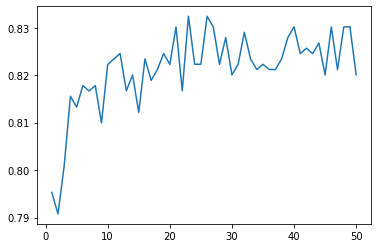

In [143]:
# 绘制学习曲线
superpa = []
for i in range(50):
    rfc = RandomForestClassifier(n_estimators=i+1
                                 ,criterion='entropy'
                                 ,max_depth=6
                                 ,min_impurity_decrease=0.0
                                 ,min_samples_leaf=1
                                )
    rfc_s = cross_val_score(rfc,x,y,cv=10,n_jobs=-1).mean()
    superpa.append(rfc_s)
print(max(superpa),superpa.index(max(superpa))+1) #注意，python中index从0开始算，index后要加1才是estimator的数量
#plt.figure(figsize=[20,5]) # 画布的长、宽
plt.plot(range(1,51),superpa)

In [162]:
rfc = RandomForestClassifier(n_estimators=100
                             ,criterion='entropy'
                             ,max_depth=6
                             ,min_impurity_decrease=0.0
                             ,min_samples_leaf=1
                             ,n_jobs=-1
                             ,oob_score=True
                            )
rfc_s = cross_val_score(rfc,x,y,cv=10,n_jobs=-1).mean()
print(rfc_s)

0.8324055158324821


In [181]:
data_test=pd.read_csv('test.csv')

In [170]:
data_test

PassengerId  Pclass                                          Name  \
0            892       3                              Kelly, Mr. James   
1            893       3              Wilkes, Mrs. James (Ellen Needs)   
2            894       2                     Myles, Mr. Thomas Francis   
3            895       3                              Wirz, Mr. Albert   
4            896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   
..           ...     ...                                           ...   
413         1305       3                            Spector, Mr. Woolf   
414         1306       1                  Oliva y Ocana, Dona. Fermina   
415         1307       3                  Saether, Mr. Simon Sivertsen   
416         1308       3                           Ware, Mr. Frederick   
417         1309       3                      Peter, Master. Michael J   

        Sex   Age  SibSp  Parch              Ticket      Fare Cabin Embarked  
0      male  34.5      0      0              330911    7.8292   NaN        Q  
1    female  47.0      1      0              363272    7.0000   NaN        S  
2      male  62.0      0      0              240276    9.6875   NaN        Q  
3      male  27.0      0      0              315154    8.6625   NaN        S  
4    female  22.0      1      1             3101298   12.2875   NaN        S  
..      ...   ...    ...    ...                 ...       ...   ...      ...  
413    male   NaN      0      0           A.5. 3236    8.0500   NaN        S  
414  female  39.0      0      0            PC 17758  108.9000  C105        C  
415    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   NaN        S  
416    male   NaN      0      0              359309    8.0500   NaN        S  
417    male   NaN      1      1                2668   22.3583   NaN        C  

[418 rows x 11 columns]

In [182]:
passengerid=data_test.loc[:,"PassengerId"]

In [183]:
##去除明显不必要的特征
data_test.drop(["PassengerId",'Cabin','Name','Ticket'],inplace=True,axis=1)

##补齐缺失值
data_test.loc[:,'Age']=data_test.loc[:,'Age'].fillna(data_test.loc[:,'Age'].mean())

data_test.loc[:,'Fare']=data_test.loc[:,'Fare'].fillna(data_test.loc[:,'Fare'].mean())

##将分类变量Sex编码
data_test.loc[:,'Sex']=(data_test.loc[:,'Sex']=='male').astype('int')

##将分类变量Embarked编码
labels=data_test.loc[:,'Embarked'].unique().tolist() 
data_test.loc[:,'Embarked']=data_test.loc[:,'Embarked'].apply(lambda x:labels.index(x))

In [186]:
rfc.fit(x,y)

<ipython-input-186-7f72057e0025>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(x,y)


RandomForestClassifier(criterion='entropy', max_depth=6, n_jobs=-1,
                       oob_score=True)

In [187]:
rfc.oob_score_

0.829021372328459

In [188]:
pre=rfc.predict(data_test)

In [189]:
file=pd.DataFrame(data={"PassengerId":passengerid,"Survived":pre})

In [193]:
file.to_csv("result.csv")